In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle
import joblib

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.lgb import fit_lgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "lgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-05 15:16:35.496130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 15:16:35.915959: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 15:16:37.235974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_120


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:30<00:00,  1.03it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
0,-86.521141,0.484678,0.484678,-11.018268,0.028438,0.001370,0.049629,957.5,0.0,44157.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,3
1,-87.261871,0.062595,0.062595,-10.602463,0.028079,0.000292,0.032782,1077.5,0.0,44277.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,3
18,-89.950226,0.048220,0.048220,-5.167186,0.028175,0.000229,0.047287,3117.5,0.0,46317.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443,3
19,-89.891479,0.075483,0.075483,-4.354149,0.028121,0.000196,0.030720,3237.5,0.0,46437.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467,3
20,-90.000000,0.000000,0.000000,-5.594111,0.028292,0.000242,0.024401,3357.5,0.0,46557.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,491,3


(537520, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_lgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["lightgbm"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        joblib.dump(model, os.path.join(CFG["output_dir"], f'lgb_{event}_fold_{i}.pkl'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)

with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.1532	valid_0's l2: 1.32986
[200]	valid_0's rmse: 1.04647	valid_0's l2: 1.0951
[300]	valid_0's rmse: 1.0188	valid_0's l2: 1.03796
[400]	valid_0's rmse: 1.01105	valid_0's l2: 1.02223
[500]	valid_0's rmse: 1.00881	valid_0's l2: 1.0177
[600]	valid_0's rmse: 1.00794	valid_0's l2: 1.01595
[700]	valid_0's rmse: 1.00717	valid_0's l2: 1.01439
[800]	valid_0's rmse: 1.00666	valid_0's l2: 1.01337
[900]	valid_0's rmse: 1.00638	valid_0's l2: 1.01279
[1000]	valid_0's rmse: 1.00621	valid_0's l2: 1.01246
[1100]	valid_0's rmse: 1.00592	valid_0's l2: 1.01187
[1200]	valid_0's rmse: 1.00577	valid_0's l2: 1.01156
[1300]	valid_0's rmse: 1.00568	valid_0's l2: 1.01139
[1400]	valid_0's rmse: 1.00549	valid_0's l2: 1.01101
[1500]	valid_0's rmse: 1.00547	valid_0's l2: 1.01097
[1600]	valid_0's rmse: 1.00521	valid_0's l2: 1.01044
[1700]	valid_0's rmse: 1.00509	valid_0's l2: 1.01021


 20%|██        | 1/5 [03:15<13:00, 195.12s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.04384	valid_0's l2: 1.0896
[200]	valid_0's rmse: 0.956049	valid_0's l2: 0.91403
[300]	valid_0's rmse: 0.931864	valid_0's l2: 0.86837
[400]	valid_0's rmse: 0.924286	valid_0's l2: 0.854305
[500]	valid_0's rmse: 0.920852	valid_0's l2: 0.847968
[600]	valid_0's rmse: 0.919518	valid_0's l2: 0.845514
[700]	valid_0's rmse: 0.918705	valid_0's l2: 0.844019
[800]	valid_0's rmse: 0.917985	valid_0's l2: 0.842696
[900]	valid_0's rmse: 0.917406	valid_0's l2: 0.841633
[1000]	valid_0's rmse: 0.91698	valid_0's l2: 0.840853
[1100]	valid_0's rmse: 0.916395	valid_0's l2: 0.83978
[1200]	valid_0's rmse: 0.915991	valid_0's l2: 0.83904
[1300]	valid_0's rmse: 0.915715	valid_0's l2: 0.838535
[1400]	valid_0's rmse: 0.915578	valid_0's l2: 0.838282
[1500]	valid_0's rmse: 0.915293	valid_0's l2: 0.837762
[1600]	valid_0's rmse: 0.915163	valid_0's l2: 0.837524
[1700]	valid_0's rmse: 0.915041	valid_0's l2: 0.8373
[1800]	valid_0's rmse: 0.914931	valid_0's l2: 0.837099
[1900]	valid_0's

 40%|████      | 2/5 [06:34<09:52, 197.59s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.0577	valid_0's l2: 1.11873
[200]	valid_0's rmse: 0.971948	valid_0's l2: 0.944683
[300]	valid_0's rmse: 0.94973	valid_0's l2: 0.901987
[400]	valid_0's rmse: 0.942407	valid_0's l2: 0.888131
[500]	valid_0's rmse: 0.939459	valid_0's l2: 0.882584
[600]	valid_0's rmse: 0.938061	valid_0's l2: 0.879959
[700]	valid_0's rmse: 0.937472	valid_0's l2: 0.878854
[800]	valid_0's rmse: 0.936848	valid_0's l2: 0.877684
[900]	valid_0's rmse: 0.936583	valid_0's l2: 0.877188
[1000]	valid_0's rmse: 0.936345	valid_0's l2: 0.876743
[1100]	valid_0's rmse: 0.936146	valid_0's l2: 0.876369
[1200]	valid_0's rmse: 0.936003	valid_0's l2: 0.876102
[1300]	valid_0's rmse: 0.935825	valid_0's l2: 0.875769
[1400]	valid_0's rmse: 0.935698	valid_0's l2: 0.875531
[1500]	valid_0's rmse: 0.935606	valid_0's l2: 0.875358
[1600]	valid_0's rmse: 0.935492	valid_0's l2: 0.875146
[1700]	valid_0's rmse: 0.935436	valid_0's l2: 0.87504
[1800]	valid_0's rmse: 0.935329	valid_0's l2: 0.87484
[1900]	valid

 60%|██████    | 3/5 [09:55<06:38, 199.19s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.1265	valid_0's l2: 1.26899
[200]	valid_0's rmse: 1.02365	valid_0's l2: 1.04785
[300]	valid_0's rmse: 0.999124	valid_0's l2: 0.998249
[400]	valid_0's rmse: 0.992737	valid_0's l2: 0.985527
[500]	valid_0's rmse: 0.990405	valid_0's l2: 0.980902
[600]	valid_0's rmse: 0.989086	valid_0's l2: 0.978291
[700]	valid_0's rmse: 0.988318	valid_0's l2: 0.976772
[800]	valid_0's rmse: 0.987734	valid_0's l2: 0.975618
[900]	valid_0's rmse: 0.987421	valid_0's l2: 0.974999
[1000]	valid_0's rmse: 0.987145	valid_0's l2: 0.974455
[1100]	valid_0's rmse: 0.986754	valid_0's l2: 0.973683
[1200]	valid_0's rmse: 0.986673	valid_0's l2: 0.973525
[1300]	valid_0's rmse: 0.986657	valid_0's l2: 0.973491
[1400]	valid_0's rmse: 0.986594	valid_0's l2: 0.973368


 80%|████████  | 4/5 [12:30<03:01, 181.62s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.05568	valid_0's l2: 1.11446
[200]	valid_0's rmse: 0.967963	valid_0's l2: 0.936952
[300]	valid_0's rmse: 0.945628	valid_0's l2: 0.894211
[400]	valid_0's rmse: 0.938956	valid_0's l2: 0.881639
[500]	valid_0's rmse: 0.936756	valid_0's l2: 0.877511
[600]	valid_0's rmse: 0.93579	valid_0's l2: 0.875703
[700]	valid_0's rmse: 0.935206	valid_0's l2: 0.87461
[800]	valid_0's rmse: 0.934915	valid_0's l2: 0.874066
[900]	valid_0's rmse: 0.934636	valid_0's l2: 0.873545
[1000]	valid_0's rmse: 0.934398	valid_0's l2: 0.8731
[1100]	valid_0's rmse: 0.934326	valid_0's l2: 0.872965
[1200]	valid_0's rmse: 0.934214	valid_0's l2: 0.872757
[1300]	valid_0's rmse: 0.934188	valid_0's l2: 0.872707
[1400]	valid_0's rmse: 0.934025	valid_0's l2: 0.872403


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[100]	valid_0's rmse: 1.15216	valid_0's l2: 1.32748
[200]	valid_0's rmse: 1.04354	valid_0's l2: 1.08898
[300]	valid_0's rmse: 1.01688	valid_0's l2: 1.03405
[400]	valid_0's rmse: 1.00902	valid_0's l2: 1.01813
[500]	valid_0's rmse: 1.00619	valid_0's l2: 1.01242
[600]	valid_0's rmse: 1.00496	valid_0's l2: 1.00995
[700]	valid_0's rmse: 1.00441	valid_0's l2: 1.00884
[800]	valid_0's rmse: 1.00407	valid_0's l2: 1.00816
[900]	valid_0's rmse: 1.0035	valid_0's l2: 1.00701
[1000]	valid_0's rmse: 1.00333	valid_0's l2: 1.00666


 20%|██        | 1/5 [02:05<08:22, 125.70s/it]

== fold 1 ==
[100]	valid_0's rmse: 1.0105	valid_0's l2: 1.0211
[200]	valid_0's rmse: 0.910133	valid_0's l2: 0.828342
[300]	valid_0's rmse: 0.882363	valid_0's l2: 0.778564
[400]	valid_0's rmse: 0.872547	valid_0's l2: 0.761338
[500]	valid_0's rmse: 0.869243	valid_0's l2: 0.755583
[600]	valid_0's rmse: 0.867876	valid_0's l2: 0.753209
[700]	valid_0's rmse: 0.866867	valid_0's l2: 0.751459
[800]	valid_0's rmse: 0.866404	valid_0's l2: 0.750655
[900]	valid_0's rmse: 0.865957	valid_0's l2: 0.749881
[1000]	valid_0's rmse: 0.865569	valid_0's l2: 0.749209
[1100]	valid_0's rmse: 0.865321	valid_0's l2: 0.748781
[1200]	valid_0's rmse: 0.865233	valid_0's l2: 0.748629
[1300]	valid_0's rmse: 0.864932	valid_0's l2: 0.748108
[1400]	valid_0's rmse: 0.86468	valid_0's l2: 0.747672
[1500]	valid_0's rmse: 0.864484	valid_0's l2: 0.747333
[1600]	valid_0's rmse: 0.864454	valid_0's l2: 0.747281


 40%|████      | 2/5 [04:56<07:37, 152.36s/it]

== fold 2 ==
[100]	valid_0's rmse: 1.044	valid_0's l2: 1.08994
[200]	valid_0's rmse: 0.952673	valid_0's l2: 0.907585
[300]	valid_0's rmse: 0.926529	valid_0's l2: 0.858456
[400]	valid_0's rmse: 0.91793	valid_0's l2: 0.842595
[500]	valid_0's rmse: 0.915024	valid_0's l2: 0.837269
[600]	valid_0's rmse: 0.91341	valid_0's l2: 0.834317
[700]	valid_0's rmse: 0.912879	valid_0's l2: 0.833348
[800]	valid_0's rmse: 0.912484	valid_0's l2: 0.832627
[900]	valid_0's rmse: 0.912394	valid_0's l2: 0.832462
[1000]	valid_0's rmse: 0.912193	valid_0's l2: 0.832096
[1100]	valid_0's rmse: 0.912078	valid_0's l2: 0.831887
[1200]	valid_0's rmse: 0.911903	valid_0's l2: 0.831568
[1300]	valid_0's rmse: 0.911802	valid_0's l2: 0.831383
[1400]	valid_0's rmse: 0.911611	valid_0's l2: 0.831035
[1500]	valid_0's rmse: 0.911636	valid_0's l2: 0.831081


 60%|██████    | 3/5 [07:41<05:15, 157.94s/it]

== fold 3 ==
[100]	valid_0's rmse: 1.13651	valid_0's l2: 1.29165
[200]	valid_0's rmse: 1.04999	valid_0's l2: 1.10248
[300]	valid_0's rmse: 1.03192	valid_0's l2: 1.06485
[400]	valid_0's rmse: 1.02719	valid_0's l2: 1.05513
[500]	valid_0's rmse: 1.02558	valid_0's l2: 1.05182
[600]	valid_0's rmse: 1.0251	valid_0's l2: 1.05083
[700]	valid_0's rmse: 1.02474	valid_0's l2: 1.05009
[800]	valid_0's rmse: 1.02444	valid_0's l2: 1.04948
[900]	valid_0's rmse: 1.02442	valid_0's l2: 1.04944


 80%|████████  | 4/5 [09:44<02:24, 144.04s/it]

== fold 4 ==
[100]	valid_0's rmse: 1.05431	valid_0's l2: 1.11158
[200]	valid_0's rmse: 0.971837	valid_0's l2: 0.944467
[300]	valid_0's rmse: 0.952771	valid_0's l2: 0.907772
[400]	valid_0's rmse: 0.947382	valid_0's l2: 0.897533
[500]	valid_0's rmse: 0.944905	valid_0's l2: 0.892846
[600]	valid_0's rmse: 0.943824	valid_0's l2: 0.890804
[700]	valid_0's rmse: 0.943327	valid_0's l2: 0.889866
[800]	valid_0's rmse: 0.942914	valid_0's l2: 0.889087
[900]	valid_0's rmse: 0.942768	valid_0's l2: 0.888811
[1000]	valid_0's rmse: 0.942802	valid_0's l2: 0.888875


100%|██████████| 5/5 [11:51<00:00, 142.36s/it]


## Dynamic-Range NMS

<AxesSubplot: >

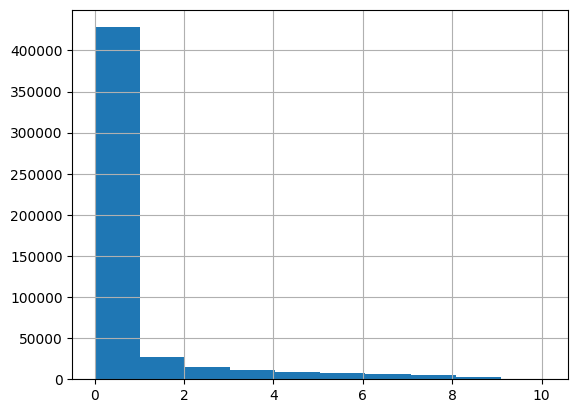

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:07<00:00, 38.53it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7794


event   tolerance
onset   12           0.265397
        36           0.680145
        60           0.775276
        90           0.820197
        120          0.840884
        150          0.857922
        180          0.868338
        240          0.884345
        300          0.891084
        360          0.895848
wakeup  12           0.226673
        36           0.695482
        60           0.780604
        90           0.821417
        120          0.846029
        150          0.861029
        180          0.872442
        240          0.890673
        300          0.901294
        360          0.912289
dtype: float64